 # LAB 7 MOS:  Simulación del Sistema de Torniquetes con SimPy

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Definicion

La Universidad de los Andes estima un crecimiento del 28 % en la población estudiantil para el año 2025, lo que genera inquietudes sobre si la infraestructura de torniquetes del edificio SD (3 de entrada, 3 de salida; incluyendo 1 de entrada y 1 de salida con QR) podrá soportar la demanda. Especificaciones operativas:

- Tiempo de pase torniquete: 5 ± 2 s

- Preparación de carnet: 10 ± 2 s

- Lectura QR: 20 ± 2 s

## **Modelo Conceptual del Sistema**

**Variables**
* Cola por torniquete: Qi = número de personas esperando en la cola del torniquete i
* Estado del torniquete: Si \in {ocupado, libre}
* Persona: m \in {carnet,QR}, d \in {in,out}, t (instante de llegada)

**Parámetros**
* Torniquetes: 3 de entrada y 3 de salida (1 para QR de cada uno)
* Tiempo de preparación de carnet: 10 ± 2 s (uniforme)
* Tiempo de lectura de qr: 20 ± 2 s (uniforme)
* Tiempo para pasar por el torniquete: 5 ± 2 s (uniforme)
* Distribución del tiempo de llegada
* Asignacion de colas: Si m = QR, va al torniquete de qr; Si m = carnet, va al torniquete con fila mas pequeña

**Métricas de Desempeño:**
* Tiempo en cola: Tiempo en salir de cola - tiempo de llegada
* Promedio de longitud de cola

**Eventos**

Llegada al edificio:
- Seleccionar torniquete i segun regla
- Si esta libre, hacer "Inicio de servicio"
- Si esta ocupado, entrar a la cola

Inicio de servicio:
- Esperar tiempo segun caracteristicas
- Hacer "Fin de servicio"

Fin de servicio:
- Registrar salida de persona
- Actualizar la cola del torniquete
- Si la cola pasa a estar vacia, actualizar su estado a libre
- Si la cola aun tiene personas, extraer una persona y hacer "Inicio de servicio"


## Carga y Analisis de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------- parámetros --------
file_path = "SD Feb-May 2019.xlsx"            # ← pon aquí la ruta correcta
sheets     = ["Feb-Mar", "Abr-May"]   # ← ajusta si cambia el nombre

# -------- lectura --------
df_list = [pd.read_excel(file_path, sheet_name=s, engine="openpyxl") for s in sheets]
df = pd.concat(df_list)

df.index = pd.to_datetime(df['fecha_completa'], format='Y-%m-%d %H:%M:%S')

In [2]:
df_filtered = (
        df.drop(columns=["PORTERIA", "RESULTADO_EVENTO", "ROL"])
        .query("MODO_ACCESO == 'Peatonal'")
        .drop(columns=["MODO_ACCESO"])
)
df_filtered["TIPO_ACCESO"] = df_filtered["TIPO_ACCESO"].str.strip()
df_filtered["DIA"] = pd.to_numeric(df_filtered["DIA"])
df_filtered.set_index(pd.to_datetime(df_filtered.index), inplace=True)

df_filtered.drop_duplicates(inplace=True)

df_filtered['day_of_week'] = df_filtered.index.day_name()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_filtered['day_of_week'] = pd.Categorical(df_filtered['day_of_week'], categories=day_order, ordered=True)

df_filtered['week'] = df_filtered.index.isocalendar().week

df_filtered['time'] = df_filtered.index.time

# Separate Entries and Exits
df_in = df_filtered[df_filtered["TIPO_ACCESO"] == "IN"]
df_out = df_filtered[df_filtered["TIPO_ACCESO"] == "OUT"]

Por dia del mes

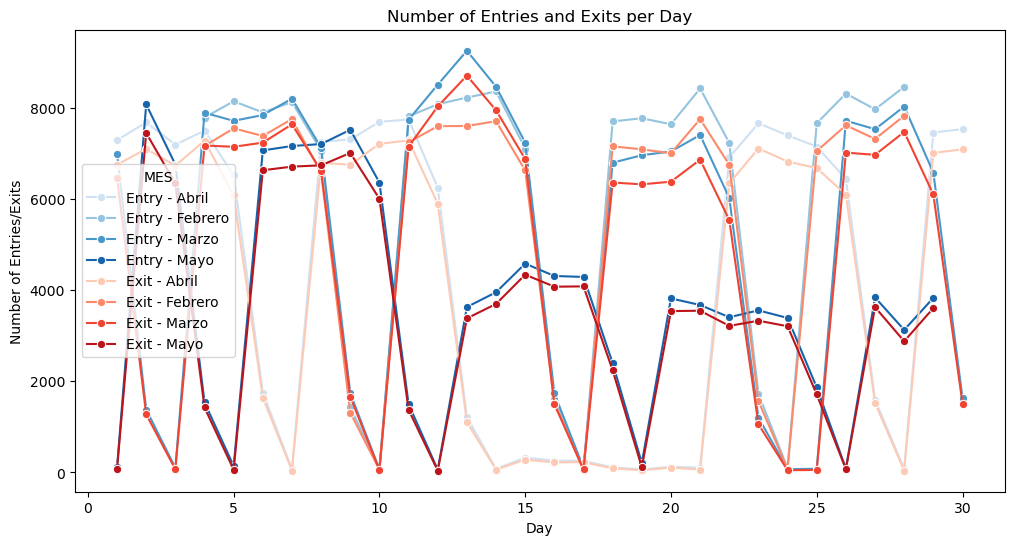

In [3]:
df_in_day = df_in.groupby(["MES", "DIA"]).size().reset_index(name="Entries")
df_out_day = df_out.groupby(["MES", "DIA"]).size().reset_index(name="Exits")

df_in_day['DAY'] = df_in_day['DIA']
df_out_day['DAY'] = df_out_day['DIA']

df_in_day['MES'] = "Entry - " + df_in_day['MES']
df_out_day['MES'] = "Exit - " + df_out_day['MES']

df_in_day = df_in_day.drop(columns=["DIA"])
df_out_day = df_out_day.drop(columns=["DIA"])

# Plotting
palette = {"Entries": sns.color_palette("Blues", 4), "Exits": sns.color_palette("Reds", 4)}
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the entries it should plot the entries per day and diferentiate by a hue applied to the month
sns.lineplot(data=df_in_day, x="DAY", y="Entries", hue="MES", marker="o", palette=palette['Entries'], ax=ax)

# Plot the exits it should plot the exits per day and diferentiate by a hue applied to the month

sns.lineplot(data=df_out_day, x="DAY", y="Exits", hue="MES", marker="o", palette=palette['Exits'], ax=ax)

# Set the title of the plot

plt.title("Number of Entries and Exits per Day")

# Set the x-axis label
plt.xlabel("Day")

# Set the y-axis label
plt.ylabel("Number of Entries/Exits")
plt.show()

Por dia de la semana en intervalos de 5 minutos

C:\Users\57313\AppData\Local\Temp\ipykernel_5280\937845871.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
C:\Users\57313\AppData\Local\Temp\ipykernel_5280\937845871.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Exits')
C:\Users\57313\AppData\Local\Temp\ipykernel_5280\937845871.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
C:\Users\57313\AppData\Local\Temp\ipykernel_5280\937845871.py:8: FutureWarning: 'T' is deprecated and will be removed in a 

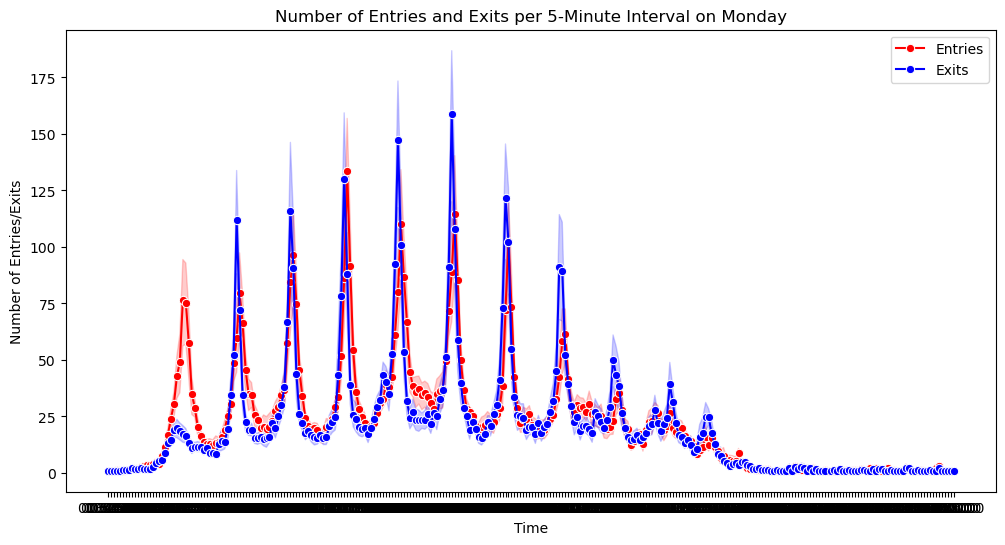

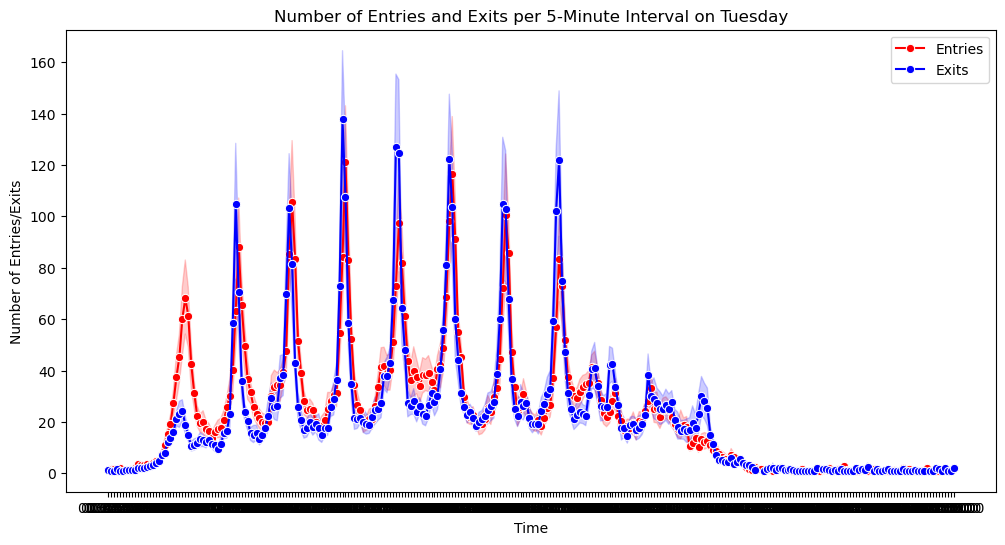

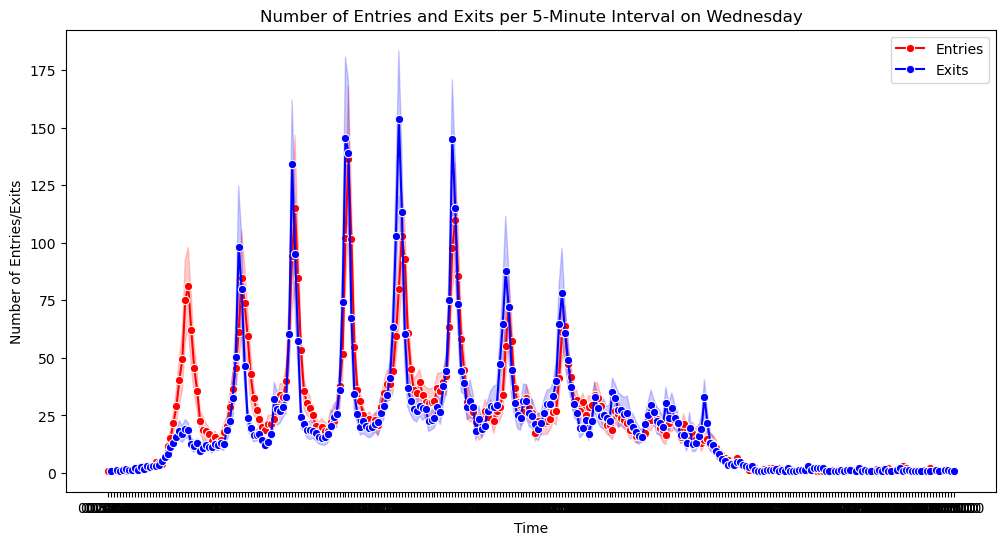

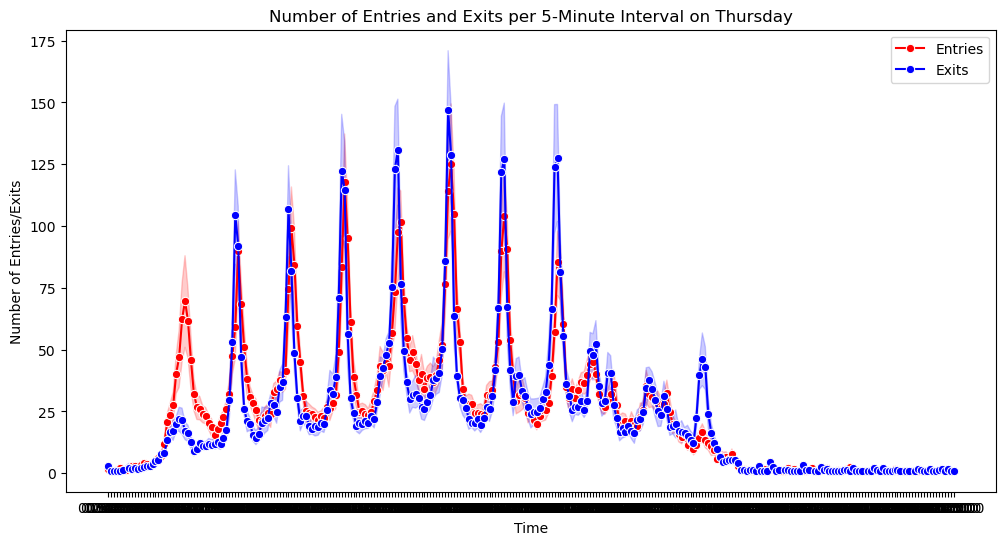

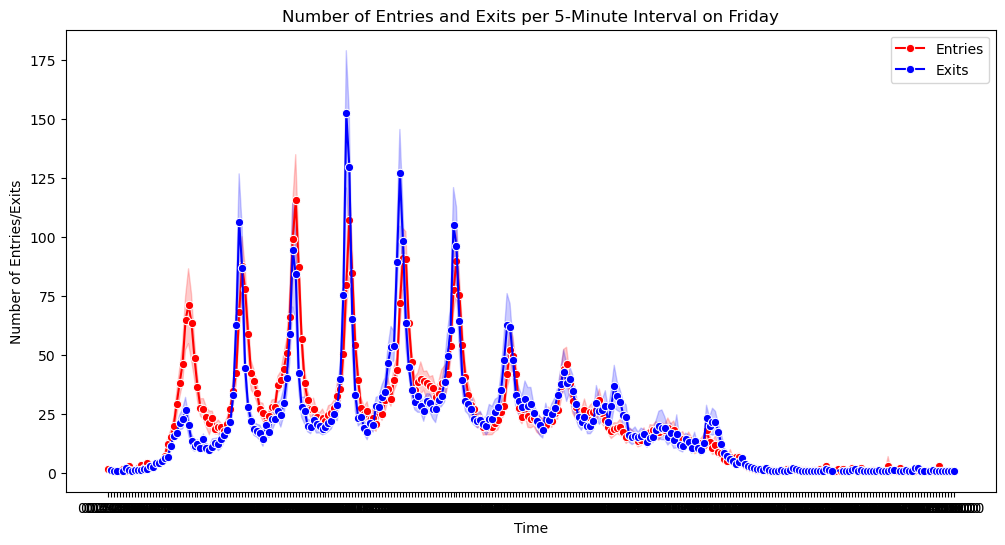

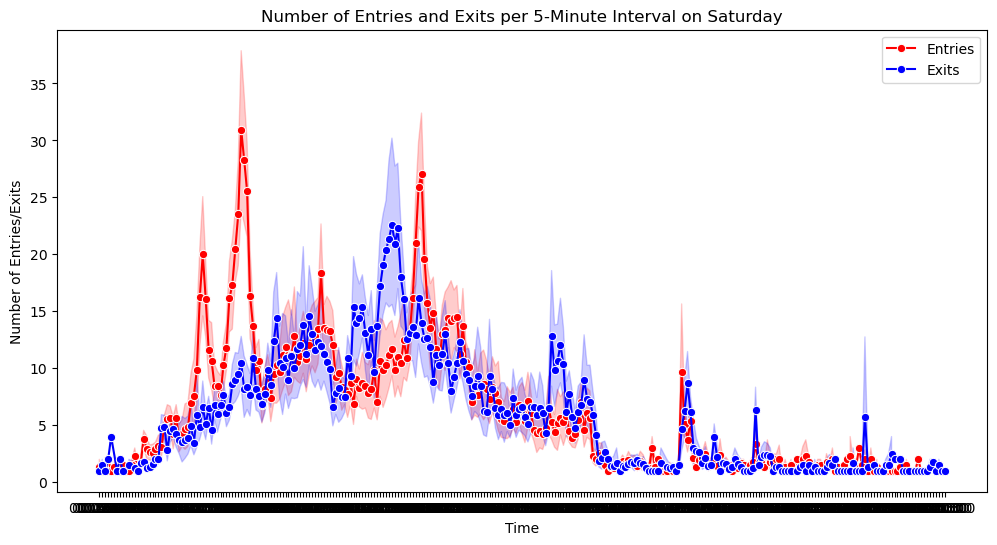

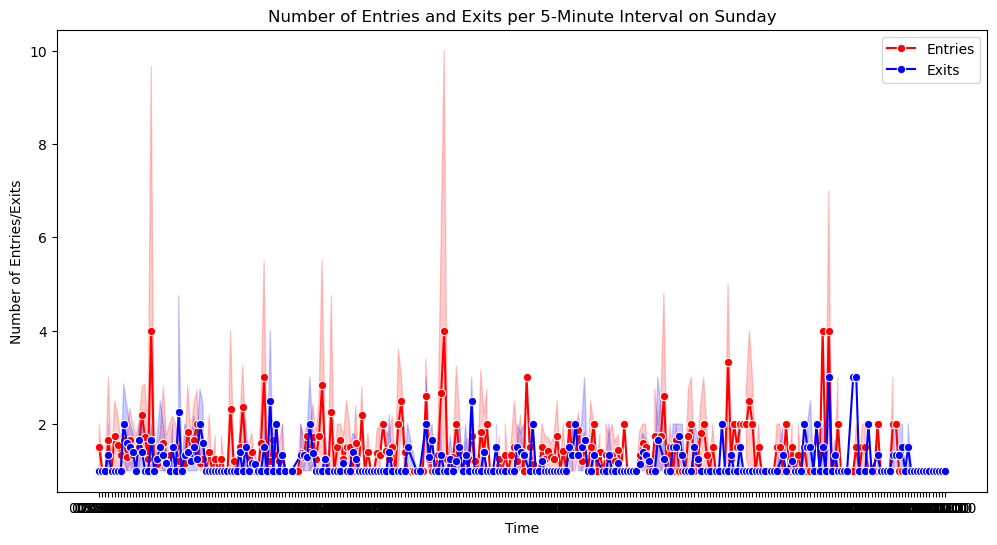

In [4]:
# Initialize dictionaries to hold DataFrames
df_in_5min = {}
df_out_5min = {}

# Group by 5-minute intervals for each day of the week
for day in df_in['day_of_week'].cat.categories:
        df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
        df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Exits')

        # Only keep non-zero entries
        df_in_day = df_in_day[df_in_day['Entries'] > 0]
        df_out_day = df_out_day[df_out_day['Exits'] > 0]

        df_in_day['time'] = df_in_day['fecha_completa'].dt.time.astype(str)
        df_out_day['time'] = df_out_day['fecha_completa'].dt.time.astype(str)

        df_in_day.set_index('time', inplace=True)
        df_out_day.set_index('time', inplace=True)

        df_in_5min[day] = df_in_day
        df_out_5min[day] = df_out_day

for day in df_in_5min.keys():
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot the entries per 5-minute interval
        sns.lineplot(data=df_in_5min[day], x=df_in_5min[day].index, y='Entries', marker='o', label='Entries', ax=ax, color='red')

        # Plot the exits per 5-minute interval
        sns.lineplot(data=df_out_5min[day], x=df_out_5min[day].index, y='Exits', marker='o', label='Exits', ax=ax, color='blue')

        # Set the title of the plot
        plt.title(f"Number of Entries and Exits per 5-Minute Interval on {day}")

        # Set the x-axis label
        plt.xlabel("Time")

        # Set the y-axis label
        plt.ylabel("Number of Entries/Exits")

        plt.legend()
        plt.show()